# Azure AI Vision OCR on a Docker

In [1]:
import docker
import os
import requests
import sys
import time

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from dotenv import load_dotenv
from io import BytesIO
from msrest.authentication import CognitiveServicesCredentials
from PIL import Image

C:\Users\seretkow\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [3]:
docker_model_endpoint = "http://127.0.0.1:5000"

In [4]:
load_dotenv("azure.env")

azure_cv_key = os.getenv("azure_cv_key")

In [5]:
try:
    response = requests.get(docker_model_endpoint)
    respcode = response.status_code
    if respcode == 200:
        print(f"OK. Status code = {respcode}")
    else:
        print(f"Failed to get status. Status code: {respcode}")

except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")

OK. Status code = 200


In [6]:
docker_client = docker.from_env()
docker_client

In [7]:
print("Active Docker container(s):\n")

for idx2, container in enumerate(docker_client.containers.list(), start=1):
    print(f"{idx2} - Docker container name: {container.name}")
    print(f"Container image: {container.image}")
    print(f"Container id: {container.id}\n")

Active Docker container(s):

1 - Docker container name: determined_einstein
Container image: <Image: 'mcr.microsoft.com/azure-cognitive-services/vision/read:latest'>
Container id: 2751ae7eea55d6d90b8165efd403537101ceeca81c67166ac6537ca49e18b029



In [8]:
docker_computervision_client = ComputerVisionClient(
    docker_model_endpoint, CognitiveServicesCredentials(azure_cv_key))

## Test 1

In [9]:
image_url = "https://learn.microsoft.com/azure/ai-services/computer-vision/media/quickstarts/presentation.png"

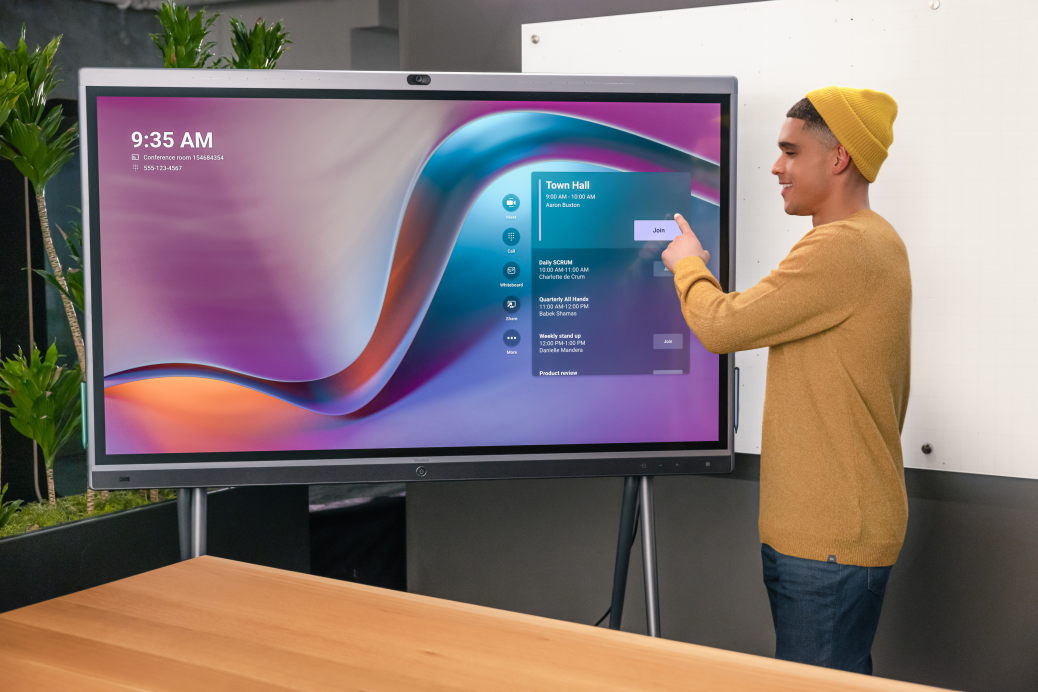

In [10]:
img = Image.open(BytesIO(requests.get(image_url).content))
img

In [11]:
read_response = docker_computervision_client.read(image_url, raw=True)
read_operation_location = read_response.headers["Operation-Location"]
operation_id = read_operation_location.split("/")[-1]

while True:
    read_result = docker_computervision_client.get_read_result(operation_id)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            print(line)

{'additional_properties': {}, 'language': None, 'bounding_box': [130.0, 129.0, 215.0, 130.0, 215.0, 149.0, 130.0, 148.0], 'appearance': <azure.cognitiveservices.vision.computervision.models._models_py3.Appearance object at 0x000001C450AC3E20>, 'text': '9:35 AM', 'words': [<azure.cognitiveservices.vision.computervision.models._models_py3.Word object at 0x000001C450AC3EB0>, <azure.cognitiveservices.vision.computervision.models._models_py3.Word object at 0x000001C450AC3F40>]}
{'additional_properties': {}, 'language': None, 'bounding_box': [131.0, 153.0, 224.0, 153.0, 224.0, 161.0, 131.0, 160.0], 'appearance': <azure.cognitiveservices.vision.computervision.models._models_py3.Appearance object at 0x000001C450AC3EE0>, 'text': 'Conference room 154584354', 'words': [<azure.cognitiveservices.vision.computervision.models._models_py3.Word object at 0x000001C450AD80A0>, <azure.cognitiveservices.vision.computervision.models._models_py3.Word object at 0x000001C450AD8130>, <azure.cognitiveservices.vi

In [12]:
if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            print(
                f"Extracted text: {line.text} Bounding box: {line.bounding_box}"
            )

Extracted text: 9:35 AM Bounding box: [130.0, 129.0, 215.0, 130.0, 215.0, 149.0, 130.0, 148.0]
Extracted text: Conference room 154584354 Bounding box: [131.0, 153.0, 224.0, 153.0, 224.0, 161.0, 131.0, 160.0]
Extracted text: Town Hall Bounding box: [545.0, 179.0, 589.0, 180.0, 589.0, 190.0, 545.0, 189.0]
Extracted text: 9:00 AM - 10:00 AM Bounding box: [545.0, 192.0, 596.0, 193.0, 596.0, 200.0, 545.0, 199.0]
Extracted text: Aston Buien Bounding box: [545.0, 201.0, 581.0, 202.0, 581.0, 208.0, 545.0, 208.0]
Extracted text: Daily SCRUM Bounding box: [537.0, 258.0, 572.0, 258.0, 572.0, 265.0, 537.0, 265.0]
Extracted text: 10:00 AM-11:00 AM Bounding box: [537.0, 266.0, 590.0, 266.0, 590.0, 272.0, 537.0, 272.0]
Extracted text: Charlathe de Crum Bounding box: [538.0, 274.0, 584.0, 273.0, 584.0, 279.0, 538.0, 279.0]
Extracted text: Quarterly NI Hands Bounding box: [538.0, 296.0, 589.0, 296.0, 589.0, 302.0, 538.0, 302.0]
Extracted text: 11:00 AM-12:00 PM Bounding box: [537.0, 303.0, 590.0, 303.0

## Test 2

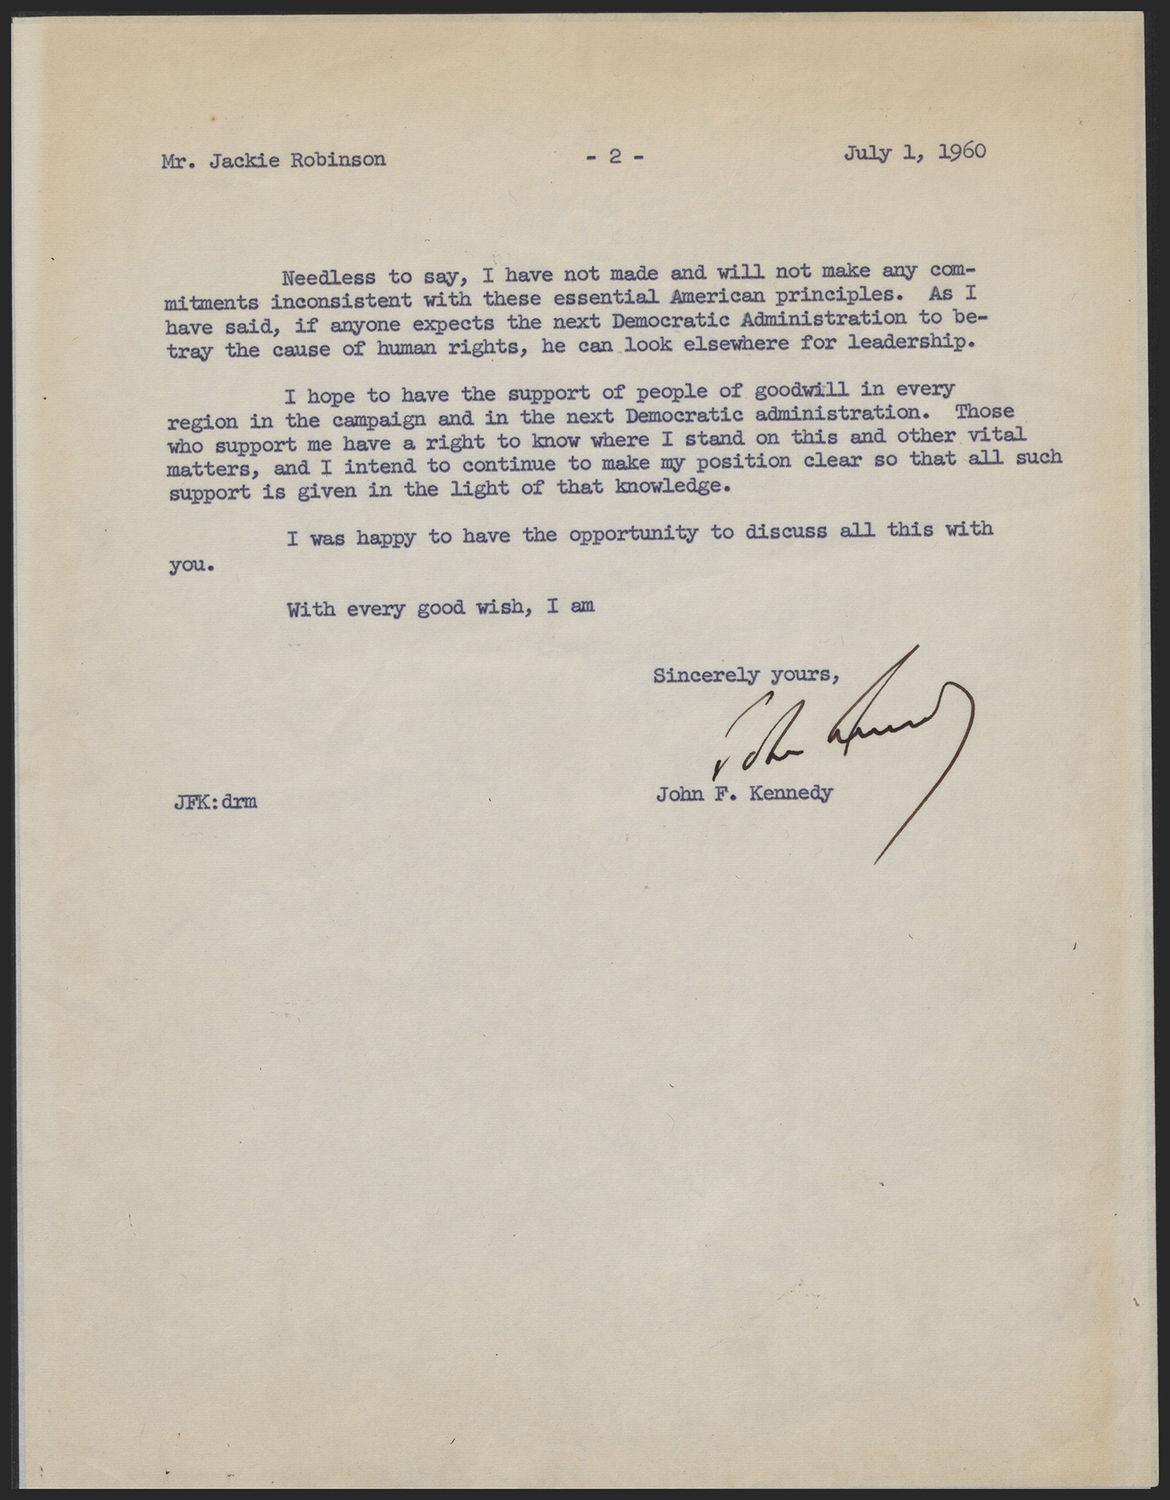

In [13]:
image_file = "letter.jpeg"

img = Image.open(image_file)
img

In [14]:
with open(image_file, "rb") as image_stream:
    read_response = docker_computervision_client.read_in_stream(image_stream, raw=True)

read_operation_location = read_response.headers["Operation-Location"]
operation_id = read_operation_location.split("/")[-1]

while True:
    read_result = docker_computervision_client.get_read_result(operation_id)
    if read_result.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

if read_result.status == OperationStatusCodes.succeeded:
    for text_result in read_result.analyze_result.read_results:
        for line in text_result.lines:
            print(line.text)

Mr. Jackie Robinson
- 2 -
July 1, 1960
Needless to say, I have not made and will not make any com-
mitments inconsistent with these essential American principles. As I
have said, if anyone expects the next Democratic Administration to be-
tray the cause of human rights, he can look elsewhere for leadership.
I hope to have the support of people of goodwill in every
region in the campaign and in the next Democratic administration. Those
who support me have a right to know where I stand on this and other vital
matters, and I intend to continue to make my position clear so that all such
support is given in the light of that knowledge.
I was happy to have the opportunity to discuss all this with
you.
With every good wish, I am
Sincerely yours,
JFK: drm
John F. Kennedy
